# Resultados simulaciones

Se revisan los resultados de las simulaciones del modelo original de Brian Arthur, barriendo los parámetros `numero de rondas de memoria` ($d$) y `tamaño bolsa predictores` ($k$).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Función para obtener los datos

In [2]:
def leer_datos(memorias, predictores, conectividades):
    names=['Identificador','Ronda','Agente','Estado','Puntaje','Politica']
    df_list = []
    for d in memorias:
        for k in predictores:
            for p in conectividades:
                print(f"Leyendo datos sweep memoria {d} predictores {k} y conectividad {p}")
                archivo = './data/simulacion-' + str(d) + "-" + str(k) + '-' + str(p) + ".csv"
                print(f"Cargando datos de archivo {archivo}...")
                try:
                    aux = pd.read_csv(archivo, names=names, header=None)
                    aux['Conectividad'] = p
                    aux['Memoria'] = d
                    aux['Num_predic'] = k
                    # print(aux.head(2))
                    df_list.append(aux)
                    print("Listo")
                except:
                    print("Archivo no existe! Saltando a siguiente opción")
    print("Preparando dataframe...")
    data = pd.concat(df_list)
    try:
        data = data.dropna()
        data['Conectividad'] = data['Conectividad'].astype(float)
        data['Memoria'] = data['Memoria'].astype(int)
        data['Num_predic'] = data['Num_predic'].astype(int)
        data['Identificador'] = data['Identificador'].astype(int)
        data['Ronda'] = data['Ronda'].astype(int)
        data['Agente'] = data['Agente'].astype(int)
        data['Estado'] = data['Estado'].astype(int)
        data['Puntaje'] = data['Puntaje'].astype(int)
        data['Politica'] = data['Politica'].astype(str)
    except:
        data = data.iloc[1:]
        data = data.dropna()
        data['Conectividad'] = data['Conectividad'].astype(float)
        data['Memoria'] = data['Memoria'].astype(int)
        data['Num_predic'] = data['Num_predic'].astype(int)
        data['Identificador'] = data['Identificador'].astype(int)
        data['Ronda'] = data['Ronda'].astype(int)
        data['Agente'] = data['Agente'].astype(int)
        data['Estado'] = data['Estado'].astype(int)
        data['Puntaje'] = data['Puntaje'].astype(int)
        data['Politica'] = data['Politica'].astype(str)
    data = data[['Conectividad','Memoria','Num_predic','Identificador','Ronda','Agente','Estado','Puntaje','Politica']]
    print("Shape:", data.shape)
    print("Memoria value counts:", data['Memoria'].value_counts())
    print("Predictores value counts:", data['Num_predic'].value_counts())
    print("Conectividades value counts:", data['Conectividad'].value_counts())
    print("Agente value counts:", data['Agente'].value_counts())
    return data

### Funciones para generar las gráficas

In [3]:
def dibuja_asistencia_vs(data, variable='Memoria'):
    Numero_agentes = max(data['Agente']) + 1
    aux = data.groupby([variable, 'Identificador', 'Ronda'])['Estado']\
        .sum().reset_index()
    aux.columns = [variable,
                   'Identificador',
                   'Ronda', 
                   'Asistencia_total']

    aux['Asistencia_total'] = (aux['Asistencia_total']/Numero_agentes)*100 
    rondas = aux['Ronda'].unique()
    aux1 = aux[aux['Ronda'] > rondas[-5]]
    aux1 = aux1.groupby([variable, 'Identificador'])['Asistencia_total']\
        .mean().reset_index()
    aux1.columns = [variable,
                   'Identificador',
                   'Asistencia_total']
    fig, ax = plt.subplots(1,2,figsize=(10,5))
    for v, grp in aux.groupby(variable):
        sns.lineplot(x=grp['Ronda'], y=grp['Asistencia_total'], label=v, ax=ax[0])
    ax[0].legend().set_title(variable)
    sns.boxplot(x=aux1[variable], y=aux1['Asistencia_total'], ax=ax[1])
    ax[0].set_xlabel('Ronda')
    ax[0].set_ylabel('Asistencia promedio')
    ax[0].set_title('Asistencia promedio por ronda')
    ax[1].set_xlabel(variable)
    ax[1].set_ylabel('Asistencia últimas 5 rondas')
    ax[1].set_title('Distribución asistencia en las últimas 5 rondas')


In [4]:
def dibujar_puntaje_vs(data, variable):
    fig, ax = plt.subplots(1,2,figsize=(10,5))
    data_aux = data.groupby([variable, 'Identificador'])['Puntaje'].mean().reset_index()
    sns.boxplot(
        x=data_aux[variable], 
        y=data_aux['Puntaje'],
        ax=ax[0]
    )
    df = data.groupby([variable, 'Identificador', 'Agente'])['Puntaje'].mean().reset_index()
    for key, grp in df.groupby(variable):
        sns.distplot(grp['Puntaje'], ax=ax[1], label=key)
    ax[1].legend().set_title(variable)
    ax[0].set_ylabel('Puntaje')
    ax[0].set_title('Distribución puntaje vs ' + variable)
    ax[1].set_xlabel('Puntaje promedio')
    ax[1].set_ylabel('')
    ax[1].set_title('Distribución de la recompensa\n por cada ' + variable)

In [5]:
def dibuja_usopredictores_vs(data, variable):
    df = data.groupby(variable)['Politica'].value_counts().rename_axis([variable, 'Politica']).reset_index(name='Usos')
    g = sns.FacetGrid(df, col=variable, aspect=1.5, height=4, sharex=False)
    g.map(sns.barplot, "Politica", "Usos")
    g.set_xticklabels(rotation=90)

In [12]:
def dibuja_puntajepredictor_vs(data, variable):
    data['Politica_lag'] = data.groupby([variable, 'Identificador', 'Agente'])['Politica'].transform('shift', -1)
    df = data.groupby([variable, 'Politica_lag', 'Identificador'])['Puntaje'].mean().reset_index()
    for p, Grp in df.groupby(variable):
        grp = Grp.sort_values(by='Puntaje')
        fig, ax = plt.subplots(1,1,figsize = (8,5))
        sns.swarmplot(x=grp['Politica_lag'], y=grp['Puntaje'])
        fig.suptitle(variable + ': ' + str(p), fontsize=14)
        plt.xticks(rotation=90)

## Simulaciones con 1 predictor conectividad 0.01 variando memoria:

**Obtener datos**

In [7]:
memorias = [1, 3, 6, 9, 12, 15, 18]
predictores = [1]
conectividades = ['0.01']
data = leer_datos(memorias, predictores, conectividades)
data.head()

Leyendo datos sweep memoria 1 predictores 1 y conectividad 0.01
Cargando datos de archivo ./data/simulacion-1-1-0.01.csv...
Listo
Leyendo datos sweep memoria 3 predictores 1 y conectividad 0.01
Cargando datos de archivo ./data/simulacion-3-1-0.01.csv...
Listo
Leyendo datos sweep memoria 6 predictores 1 y conectividad 0.01
Cargando datos de archivo ./data/simulacion-6-1-0.01.csv...
Listo
Leyendo datos sweep memoria 9 predictores 1 y conectividad 0.01
Cargando datos de archivo ./data/simulacion-9-1-0.01.csv...
Listo
Leyendo datos sweep memoria 12 predictores 1 y conectividad 0.01
Cargando datos de archivo ./data/simulacion-12-1-0.01.csv...
Listo
Leyendo datos sweep memoria 15 predictores 1 y conectividad 0.01
Cargando datos de archivo ./data/simulacion-15-1-0.01.csv...
Listo
Leyendo datos sweep memoria 18 predictores 1 y conectividad 0.01
Cargando datos de archivo ./data/simulacion-18-1-0.01.csv...
Listo
Preparando dataframe...
Shape: (7000000, 9)
Memoria value counts: 18    1000000
15  

Conectividad  Memoria  Num_predic  Identificador  Ronda  Agente  Estado  \
1 1          0.01        1           1            100      0       0       0   
  1          0.01        1           1            100      1       0       1   
  1          0.01        1           1            100      2       0       1   
  1          0.01        1           1            100      3       0       1   
  1          0.01        1           1            100      4       0       1   

     Puntaje          Politica  
1 1        0         1-ventana  
  1       -1  1-ventana-espejo  
  1       -1  1-ventana-espejo  
  1       -1  1-ventana-espejo  
  1        1  1-ventana-espejo

**Asistencia**

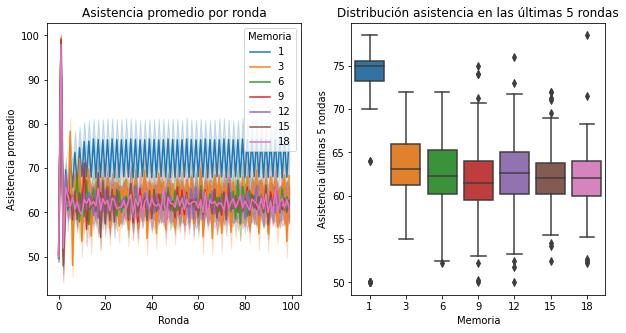

In [8]:
dibuja_asistencia_vs(data, 'Memoria')

#### Recompensa total

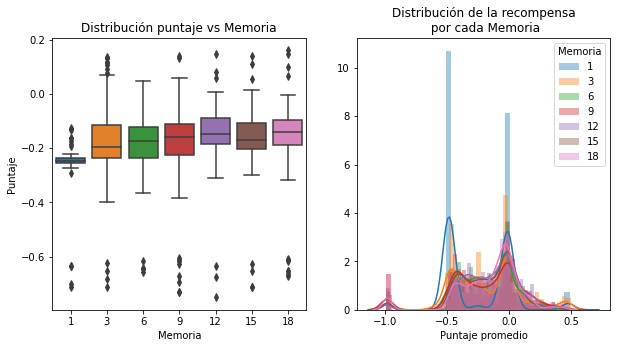

In [9]:
dibujar_puntaje_vs(data, 'Memoria')

**Uso de políticas**

/usr/local/lib/python3.8/site-packages/seaborn/axisgrid.py:723: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


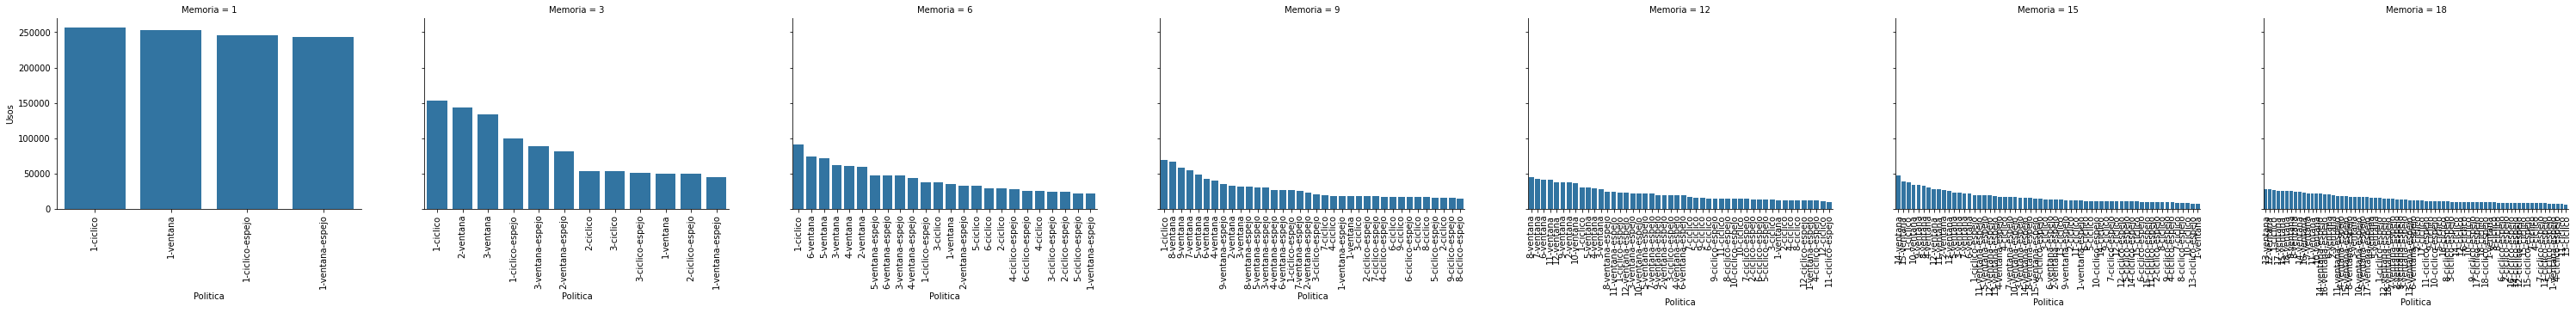

In [10]:
dibuja_usopredictores_vs(data, 'Memoria')

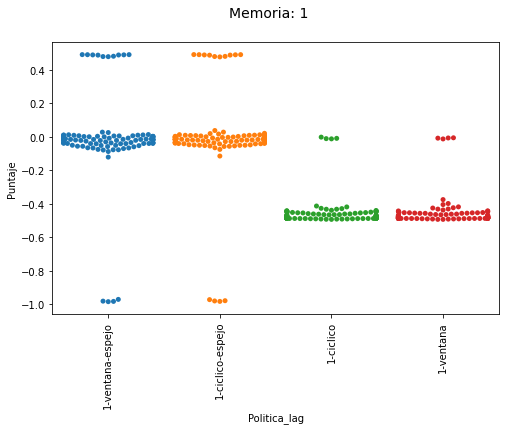

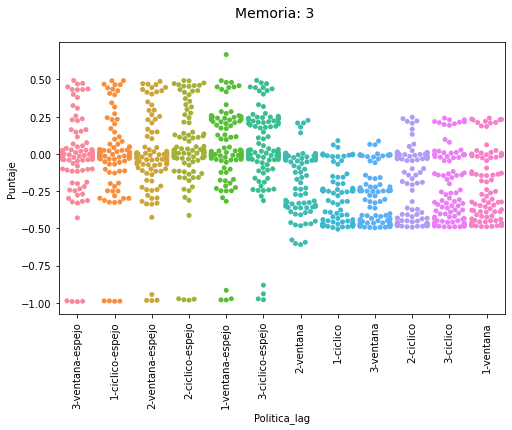

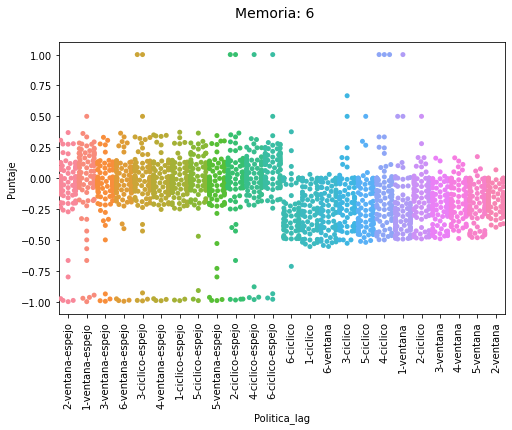

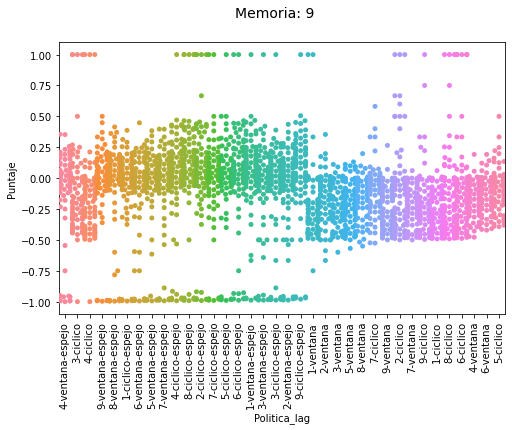

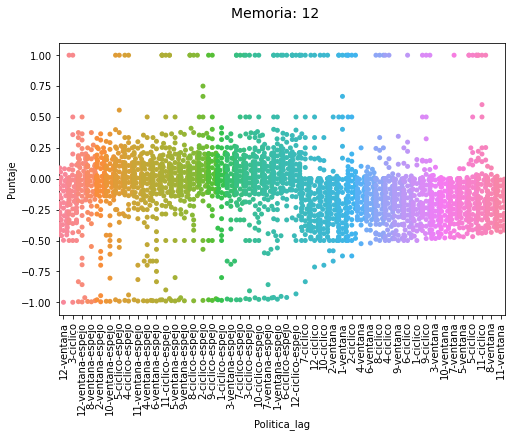

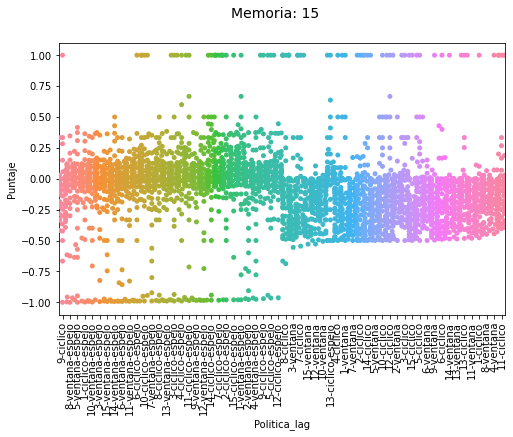

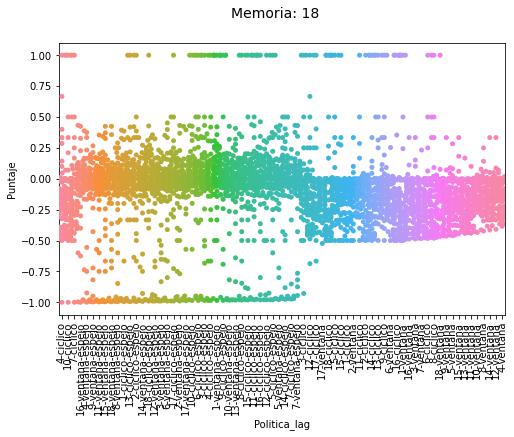

In [13]:
dibuja_puntajepredictor_vs(data, 'Memoria')